In [11]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

pd.set_option("display.max_columns", 100)

In [12]:
dir_path = "../input/indoorpkl/"
train_file_name = dir_path + "indoor_train.pkl"
test_file_name = dir_path + "indoor_test.pkl"

# Try loading it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [13]:
# Visualizing timestamp distribution
# LabelEncode site_id, file_id, floor_converted, ssid, bssid
def col_encode(df, cols):
    for col in cols:
        le = preprocessing.LabelEncoder()
        df["%s_le"%col] = le.fit_transform(df[col])

col_enc = ["site_id", "file_id", "floor_converted", "wifi_ssid", "wifi_bssid"]
col_encode(df_train, col_enc)
col_encode(df_test, col_enc)

# convert data types of certain columns
def convert_dtypes(df, col_list, dtype):
    for col in col_list:
        df[col] = df[col].astype(dtype)

convert_dtypes(df_train, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                          "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"], float)

convert_dtypes(df_test, ["ts", "start_ts", "diff_start_ts", "acce_ts", "ahrs_ts", "magn_ts", \
                          "wifi_ts", "wifi_rssi", "wifi_freq", "wifi_last_seen_ts", \
                          "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                          "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"], float)

# convert ts and wifi_last_see_ts to dates
for df in [df_train, df_test]:
    for col in ["ts", "wifi_last_seen_ts"]:
        df["%s_date"%col] = pd.to_datetime(df[col],unit="ms")
        df["%s_day"%col] = df["%s_date"%col].dt.floor("d")
        df["%s_hour"%col] = df["%s_date"%col].dt.floor("h")
        df["%s_minute"%col] = df["%s_date"%col].values.astype("<M8[m]")

# Check
display(df_train.head())
display(df_test.head())

,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,0.0,1.560913e+12,-0.210693,-0.304062,9.943115,NaN,1.560913e+12,-0.012902,0.008711,-0.427844,NaN,1.560913e+12,-21.720000,17.76,-36.120000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90.0,NaN,1.560913e+12,186.0,186.0,186.0,530.0,0,3,0,22,19,2019-06-19 03:02:49.585999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:43.913999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1,B1,1.560913e+12,21.157534,30.024122,1.560913e+12,9886.0,1.560913e+12,-0.718262,-0.418991,10.347733,NaN,1.560913e+12,-0.006788,0.039279,-0.327645,NaN,1.560913e+12,-19.260000,18.90,-30.179998,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-84.0,NaN,1.560913e+12,9895.0,9895.0,9895.0,9998.0,0,3,0,22,19,2019-06-19 03:02:59.472000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:52.752999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,10.195710,21.657787,1.560913e+12,0.0,1.560913e+12,0.043091,0.275330,9.428360,NaN,1.560913e+12,0.000129,0.000146,-0.757510,NaN,1.560913e+12,-24.180000,-5.16,-26.640000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-87.0,NaN,1.560913e+12,192.0,192.0,192.0,502.0,0,2,0,22,19,2019-06-19 03:00:25.966000128,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:22.655000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,5292.0,1.560913e+12,-0.541092,1.374268,10.240006,NaN,1.560913e+12,0.078497,-0.037847,-0.717117,NaN,1.560913e+12,-23.820000,-6.90,-26.880000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-76.0,NaN,1.560913e+12,5284.0,5284.0,5284.0,5531.0,0,2,0,22,19,2019-06-19 03:00:31.257999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:31.092000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
2,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1,B1,1.560913e+12,21.089481,19.001072,1.560913e+12,13045.0,1.560913e+12,-0.131683,0.172379,10.309433,NaN,1.560913e+12,0.017186,-0.002997,-0.696129,NaN,1.560913e+12,-26.699999,1.86,-10.620000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-79.0,NaN,1.560913e+12,13051.0,13051.0,13051.0,13216.0,0,2,0,22,19,2019-06-19 03:00:39.011000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:33.140999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00


,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,9.0,NaN,NaN,0.0,9.0,136.0,0.798813,4.300720,7.810059,NaN,136.0,0.247101,0.104201,0.474897,NaN,136.0,30.561829,-1.228333,-38.301086,NaN,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,136.0,136.0,136.0,2340.0,0,0,0,108,264,1970-01-01 00:00:00.009,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
1,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,9017.0,NaN,NaN,0.0,9017.0,9012.0,-1.106979,4.056503,9.795456,NaN,9012.0,0.162119,0.185954,0.561409,NaN,9012.0,29.867554,-6.085205,-26.150513,NaN,9508.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,-43.0,NaN,1.578475e+12,9012.0,9012.0,9012.0,9508.0,0,0,0,108,35,1970-01-01 00:00:09.017,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:30.052000000,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
2,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,15326.0,NaN,NaN,0.0,15326.0,15326.0,-0.572464,3.981689,7.082230,NaN,15326.0,0.225070,0.022647,-0.200452,NaN,15326.0,-6.207275,14.727783,-39.649963,NaN,14714.0,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b26914599f6d9ba16b43975394e1eeb9d82f4bab,-41.0,NaN,1.578475e+12,15326.0,15326.0,15326.0,14714.0,0,0,0,79,208,1970-01-01 00:00:15.326,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:38.027000064,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
3,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,18763.0,NaN,NaN,0.0,18763.0,18755.0,-0.751434,4.546112,10.231201,NaN,18755.0,0.225055,0.044806,-0.119175,NaN,18755.0,-1.350403,9.870911,-41.676330,NaN,19587.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,-41.0,NaN,1.578475e+12,18755.0,18755.0,18755.0,19587.0,0,0,0,108,249,1970-01-01 00:00:18.763,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:42.716999936,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
4,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,22328.0,NaN,NaN,0.0,22328.0,22326.0,-2.089798,4.224701,12.037628,NaN,22326.0,0.242105,0.053464,-0.008162,NaN,22326.0,-1.350403,5.014038,-30.876160,NaN,22074.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,1d1d62dcf72481cc9580fed3b724f0d27015aaf1,-42.0,NaN,1.578475e+12,22326.0,22326.0,22326.0,22074.0,0,0,0,108,35,1970-01-01 00:00:22.328,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:34.860999936,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00


In [14]:
# Add names to df for later use
df_train.name = "df_train"
df_test.name = "df_test"

# prepare concatenated df for later use
df_test["is_train"] = 0
df_train["is_train"] = 1
df_combine = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Re-LabelEncode the concat df
col_enc = ["site_id", "file_id", "floor_converted", "wifi_ssid", "wifi_bssid"]
col_encode(df_combine, col_enc)
print(df_combine.columns.values)
display(df_combine.head())

# Split combine data again to have common LabelEncoding
df_combine_train = df_combine[df_combine["is_train"] == 1]
df_combine_test = df_combine[df_combine["is_train"] == 0]
df_combine_train.name = "df_train"
df_combine_test.name = "df_test"

# Narrow combined df down to numeric ones only
drop_non_num_cols_train = ["site_id", "file_id",  \
              "ts", "start_ts", "diff_start_ts", "acce_ts", "acce_acc", \
              "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts", \
              "site_id_le", "file_id_le", "floor_converted_le", "wifi_ssid_le", "wifi_bssid", "is_train"
            ]

drop_non_num_cols = ["site_id", "file_id",  \
              "ts", "start_ts", "diff_start_ts", "acce_ts", "acce_acc", \
              "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts", \
              "site_id_le", "file_id_le", "floor_converted_le", "wifi_ssid_le", "wifi_bssid_le"
            ]

# Drop the timestamps except for diff_start_ts, and keep the encoded fields
drop_ts_cols = ["site_id", "file_id",  \
              "ts", "start_ts", "acce_ts", "acce_acc", \
              "ahrs_ts", "ahrs_acc", "magn_ts","magn_acc", \
              "wifi_ts", "wifi_ssid", "wifi_bssid", "wifi_freq", "wifi_last_seen_ts", \
              "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
              "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"
            ]

# Setting for limiting how many examples to visualize
reduce_ex = 1000

# reduced and numeric-col-only df_train
df_train_reduced = df_train.iloc[:reduce_ex, :]
df_train_num = df_train_reduced.drop(columns=drop_non_num_cols_train)

# reduced and numeric-col-only df_train for correlation mapping
df_train_num_le = df_train_reduced.drop(columns=drop_ts_cols)

# numeric-col-only df_combine
df_combine_reduced = df_combine.sample(frac=1)
df_combine_reduced = df_combine_reduced.iloc[:reduce_ex, :]
df_combine_num = df_combine_reduced.drop(columns=drop_non_num_cols)

# Check dfs
display(df_train_num.head())
display(df_train_num_le.head())
display(df_combine_num.head())

['site_id' 'file_id' 'floor_converted' 'floor' 'ts' 'x' 'y' 'start_ts'
 'diff_start_ts' 'acce_ts' 'acce_x' 'acce_y' 'acce_z' 'acce_acc' 'ahrs_ts'
 'ahrs_x' 'ahrs_y' 'ahrs_z' 'ahrs_acc' 'magn_ts' 'magn_x' 'magn_y'
 'magn_z' 'magn_acc' 'wifi_ts' 'wifi_ssid' 'wifi_bssid' 'wifi_rssi'
 'wifi_freq' 'wifi_last_seen_ts' 'diff_acce_ts_start_ts'
 'diff_ahrs_ts_start_ts' 'diff_magn_ts_start_ts' 'diff_wifi_ts_start_ts'
 'site_id_le' 'file_id_le' 'floor_converted_le' 'wifi_ssid_le'
 'wifi_bssid_le' 'ts_date' 'ts_day' 'ts_hour' 'ts_minute'
 'wifi_last_seen_ts_date' 'wifi_last_seen_ts_day' 'wifi_last_seen_ts_hour'
 'wifi_last_seen_ts_minute' 'is_train']


,site_id,file_id,floor_converted,floor,ts,x,y,start_ts,diff_start_ts,acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,magn_x,magn_y,magn_z,magn_acc,wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,diff_acce_ts_start_ts,diff_ahrs_ts_start_ts,diff_magn_ts_start_ts,diff_wifi_ts_start_ts,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,is_train
0,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1.0,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,0.0,1.560913e+12,-0.210693,-0.304062,9.943115,NaN,1.560913e+12,-0.012902,0.008711,-0.427844,NaN,1.560913e+12,-21.720000,17.76,-36.120000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-90.0,NaN,1.560913e+12,186.0,186.0,186.0,530.0,2,27,0,108,113,2019-06-19 03:02:49.585999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:43.913999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,1
1,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb9,-1.0,B1,1.560913e+12,21.157534,30.024122,1.560913e+12,9886.0,1.560913e+12,-0.718262,-0.418991,10.347733,NaN,1.560913e+12,-0.006788,0.039279,-0.327645,NaN,1.560913e+12,-19.260000,18.90,-30.179998,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-84.0,NaN,1.560913e+12,9895.0,9895.0,9895.0,9998.0,2,27,0,108,113,2019-06-19 03:02:59.472000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:52.752999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,1
2,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1.0,B1,1.560913e+12,10.195710,21.657787,1.560913e+12,0.0,1.560913e+12,0.043091,0.275330,9.428360,NaN,1.560913e+12,0.000129,0.000146,-0.757510,NaN,1.560913e+12,-24.180000,-5.16,-26.640000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-87.0,NaN,1.560913e+12,192.0,192.0,192.0,502.0,2,26,0,108,113,2019-06-19 03:00:25.966000128,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:22.655000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,1
3,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1.0,B1,1.560913e+12,14.283729,20.392578,1.560913e+12,5292.0,1.560913e+12,-0.541092,1.374268,10.240006,NaN,1.560913e+12,0.078497,-0.037847,-0.717117,NaN,1.560913e+12,-23.820000,-6.90,-26.880000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-76.0,NaN,1.560913e+12,5284.0,5284.0,5284.0,5531.0,2,26,0,108,113,2019-06-19 03:00:31.257999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:31.092000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,1
4,5cd56c0ce2acfd2d33b6ab27,5d09a625bd54340008acddb7,-1.0,B1,1.560913e+12,21.089481,19.001072,1.560913e+12,13045.0,1.560913e+12,-0.131683,0.172379,10.309433,NaN,1.560913e+12,0.017186,-0.002997,-0.696129,NaN,1.560913e+12,-26.699999,1.86,-10.620000,NaN,1.560913e+12,bd56240b1064c9e8e62ec3b8b1825d1104c16dcc,51e058eb65d3e5b3838e8dba0f3006028d5fd864,-79.0,NaN,1.560913e+12,13051.0,13051.0,13051.0,13216.0,2,26,0,108,113,2019-06-19 03:00:39.011000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:33.140999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,1


,floor_converted,floor,x,y,acce_x,acce_y,acce_z,ahrs_x,ahrs_y,ahrs_z,magn_x,magn_y,magn_z,wifi_rssi,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,-1,B1,14.283729,20.392578,-0.210693,-0.304062,9.943115,-0.012902,0.008711,-0.427844,-21.720000,17.76,-36.120000,-90.0,19,2019-06-19 03:02:49.585999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:43.913999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
1,-1,B1,21.157534,30.024122,-0.718262,-0.418991,10.347733,-0.006788,0.039279,-0.327645,-19.260000,18.90,-30.179998,-84.0,19,2019-06-19 03:02:59.472000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:52.752999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00
0,-1,B1,10.195710,21.657787,0.043091,0.275330,9.428360,0.000129,0.000146,-0.757510,-24.180000,-5.16,-26.640000,-87.0,19,2019-06-19 03:00:25.966000128,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:22.655000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
1,-1,B1,14.283729,20.392578,-0.541092,1.374268,10.240006,0.078497,-0.037847,-0.717117,-23.820000,-6.90,-26.880000,-76.0,19,2019-06-19 03:00:31.257999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:31.092000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00
2,-1,B1,21.089481,19.001072,-0.131683,0.172379,10.309433,0.017186,-0.002997,-0.696129,-26.699999,1.86,-10.620000,-79.0,19,2019-06-19 03:00:39.011000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:33.140999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00


,floor_converted,floor,x,y,diff_start_ts,acce_x,acce_y,acce_z,ahrs_x,ahrs_y,ahrs_z,magn_x,magn_y,magn_z,wifi_rssi,site_id_le,file_id_le,floor_converted_le,wifi_ssid_le,wifi_bssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,is_train
0,-1,B1,14.283729,20.392578,0.0,-0.210693,-0.304062,9.943115,-0.012902,0.008711,-0.427844,-21.720000,17.76,-36.120000,-90.0,0,3,0,22,19,2019-06-19 03:02:49.585999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:43.913999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,1
1,-1,B1,21.157534,30.024122,9886.0,-0.718262,-0.418991,10.347733,-0.006788,0.039279,-0.327645,-19.260000,18.90,-30.179998,-84.0,0,3,0,22,19,2019-06-19 03:02:59.472000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,2019-06-19 03:02:52.752999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:02:00,1
0,-1,B1,10.195710,21.657787,0.0,0.043091,0.275330,9.428360,0.000129,0.000146,-0.757510,-24.180000,-5.16,-26.640000,-87.0,0,2,0,22,19,2019-06-19 03:00:25.966000128,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:22.655000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,1
1,-1,B1,14.283729,20.392578,5292.0,-0.541092,1.374268,10.240006,0.078497,-0.037847,-0.717117,-23.820000,-6.90,-26.880000,-76.0,0,2,0,22,19,2019-06-19 03:00:31.257999872,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:31.092000000,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,1
2,-1,B1,21.089481,19.001072,13045.0,-0.131683,0.172379,10.309433,0.017186,-0.002997,-0.696129,-26.699999,1.86,-10.620000,-79.0,0,2,0,22,19,2019-06-19 03:00:39.011000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,2019-06-19 03:00:33.140999936,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:00:00,1


,floor_converted,floor,x,y,acce_x,acce_y,acce_z,ahrs_x,ahrs_y,ahrs_z,magn_x,magn_y,magn_z,wifi_rssi,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,is_train
204,1.0,F1,81.263245,97.681320,-1.161713,1.164108,13.403397,0.043369,0.012407,-0.474256,-30.119999,7.20000,-32.820000,-59.0,2019-06-21 02:25:27.603000064,2019-06-21,2019-06-21 02:00:00,2019-06-21 02:25:00,2019-06-21 02:25:26.832999936,2019-06-21,2019-06-21 02:00:00,2019-06-21 02:25:00,1
841,NaN,NaN,NaN,NaN,-0.667084,0.999557,10.601639,0.059685,0.000445,-0.627661,-25.111390,4.66156,-27.011108,-41.0,1970-01-01 00:01:15.100000000,1970-01-01,1970-01-01 00:00:00,1970-01-01 00:01:00,2019-09-27 06:54:32.352999936,2019-09-27,2019-09-27 06:00:00,2019-09-27 06:54:00,0
123,-1.0,B1,176.707980,94.503530,-0.064606,0.880554,11.272583,0.020982,-0.046207,-0.993086,-11.219999,-26.58000,-20.400000,-84.0,2019-06-21 00:20:29.880000000,2019-06-21,2019-06-21 00:00:00,2019-06-21 00:20:00,2019-06-21 00:20:28.956999936,2019-06-21,2019-06-21 00:00:00,2019-06-21 00:20:00,1
56,2.0,F2,65.660290,30.501722,0.105347,0.335190,9.605530,0.008500,0.018085,0.790029,23.580000,-4.80000,-33.300000,-74.0,2019-06-19 03:16:39.155000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:16:00,2019-06-19 03:16:19.387000064,2019-06-19,2019-06-19 03:00:00,2019-06-19 03:16:00,1
244,1.0,F1,58.894367,80.669920,-0.323044,1.091125,9.223145,0.062817,-0.014046,-0.449412,-25.500000,14.28000,-34.860000,-87.0,2019-06-21 02:13:21.480999936,2019-06-21,2019-06-21 02:00:00,2019-06-21 02:13:00,2019-06-21 02:13:12.256000000,2019-06-21,2019-06-21 02:00:00,2019-06-21 02:13:00,1


In [15]:
# how to annotate inside the graph -> to show min, max, diff
# https://analytics-note.xyz/programming/matplotlib-text-trans-axes/
def bin_plot(df, col, title, x_label, y_label):
    min_v = pd.to_numeric(df[col]).min()
    max_v = pd.to_numeric(df[col]).max()
    diff = max_v - min_v
    fig = plt.figure(figsize=(16.0, 4.0))
    ax = fig.add_subplot(1,1,1)
    ax.hist(df[col], bins=30)
    ax.set_title(title)
    # ax.set_xlabel(x_label)
    ax.text(0.01, 0.99, "min is {}, max is {}, diff is {}".format(min_v, max_v, diff), verticalalignment='top', transform=ax.transAxes)
    ax.set_ylabel(y_label)
    plt.xticks(rotation=90)
    fig.show()


# wifi last seen distribution
def plot_ts_frequency(df, cols):
    df_list = []
    for col in cols:
        df_count = df[col].value_counts().reset_index()
        df_count = df_count.sort_values("index", ascending=True)
        df_list.append(df_count)
    
    df_name = df.name
    col_len = len(cols)
    fig, axes = plt.subplots(ncols=col_len, figsize=(16, 10))

    for i, df in enumerate(df_list):
        col_names = df.columns.values
        axes[i] = sns.barplot(data=df, x=col_names[1], y="index", palette="viridis", saturation=0.4, ax=axes[i])
        axes[i].set_title(f"{df_name}, {col_names[1]}", size = 26, weight="bold")
        #plt.xticks([])
        plt.yticks(fontsize=11)
        sns.despine(left=True, bottom=True);

# # Binned Histogram of ts/wifi_last_seen dates, hours, minutes
# # subplot ref -> https://qiita.com/nkay/items/d1eb91e33b9d6469ef51
# def ts_date_bin_plot(df, col, title, x_label, y_label):
#     fig = plt.figure(figsize=(16.0, 4.0))
#     ax = fig.add_subplot(1,1,1)
#     ax.hist(df[col], bins=30)
#     ax.set_title(title)
#     ax.set_ylabel(y_label)
#     plt.xticks(rotation=90)
#     fig.show()

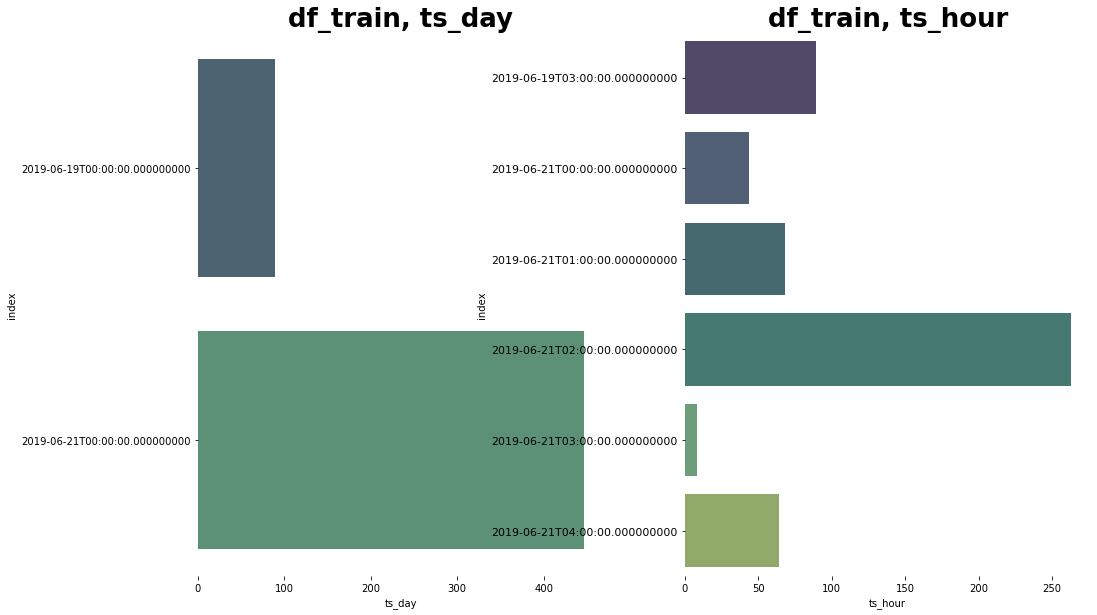

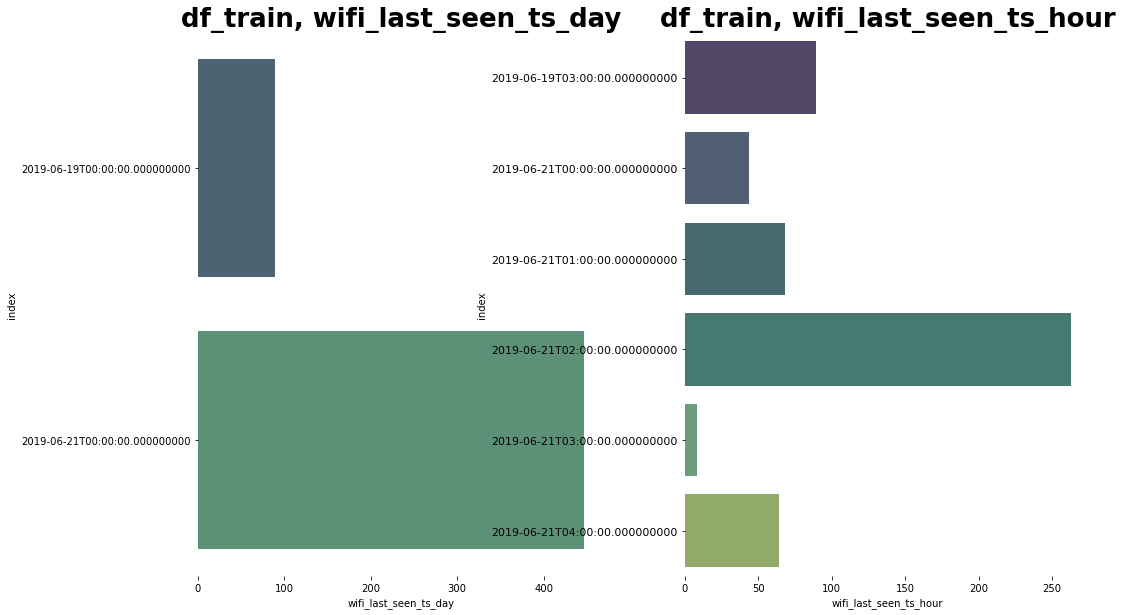

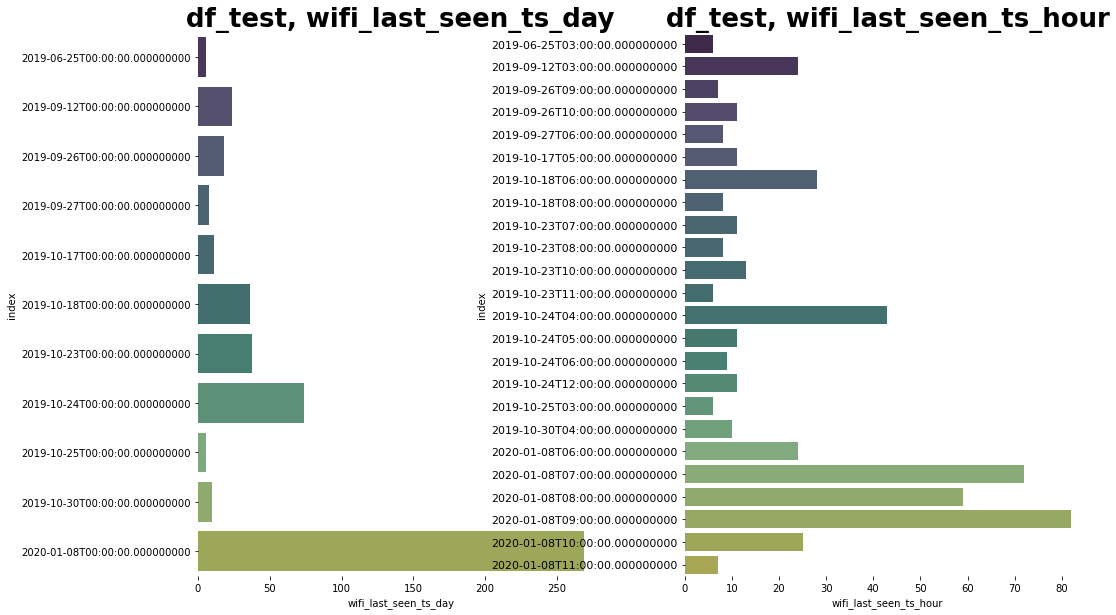

In [16]:
# Check wifi last seen distribution
plot_ts_frequency(df_train, ["ts_day", "ts_hour"])
plot_ts_frequency(df_train, ["wifi_last_seen_ts_day", "wifi_last_seen_ts_hour"])
plot_ts_frequency(df_test, ["wifi_last_seen_ts_day", "wifi_last_seen_ts_hour"])

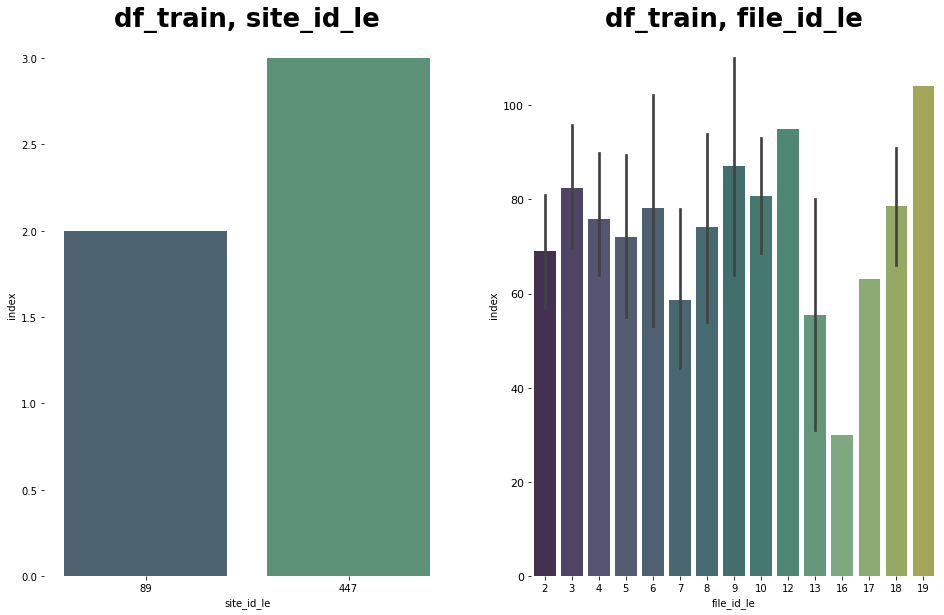

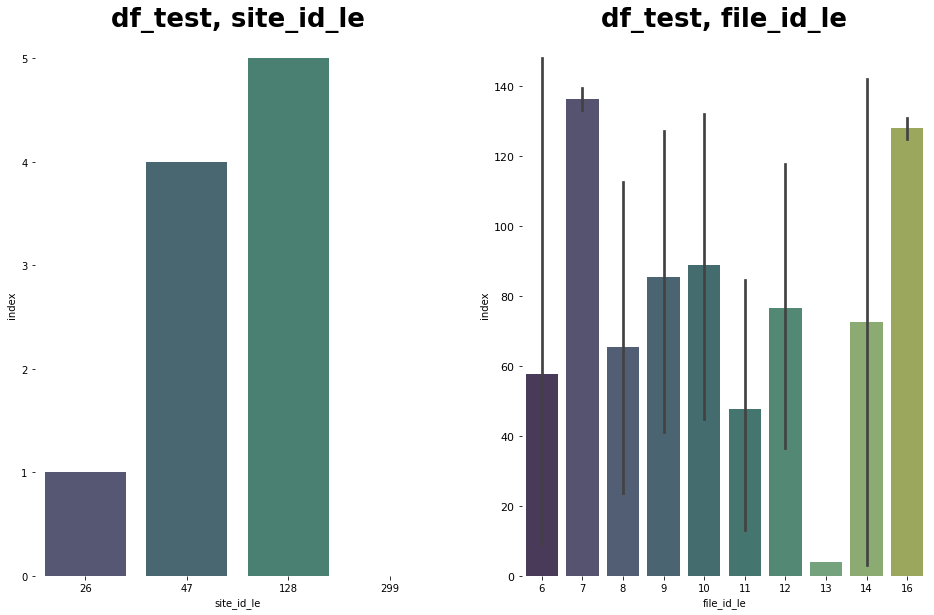

In [17]:
# Show site_id, file_id, wifi_ssid, wifi_bssid for train and test
plot_ts_frequency(df_combine_train, ["site_id_le", "file_id_le"])
plot_ts_frequency(df_combine_test, ["site_id_le", "file_id_le"])

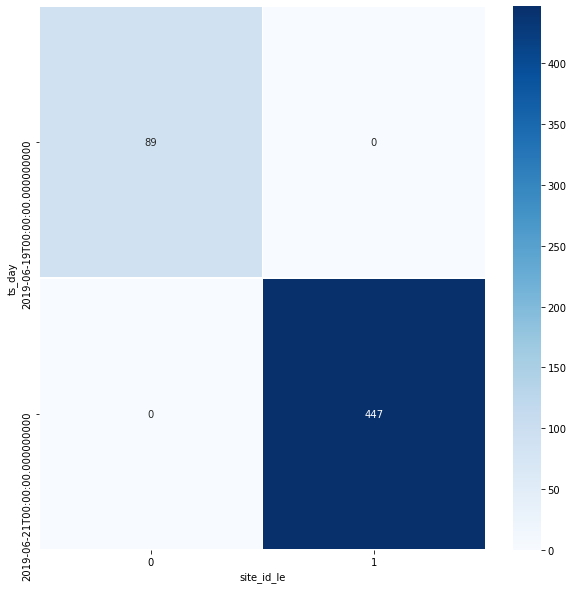

In [24]:
# Check dates distribution by heatmap -> Only train data because it uses ts
# Mostly one building is measured in one day, but has some exceptions like building "7" below
piv_df = df_train.pivot_table(index="ts_day", columns="site_id_le", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

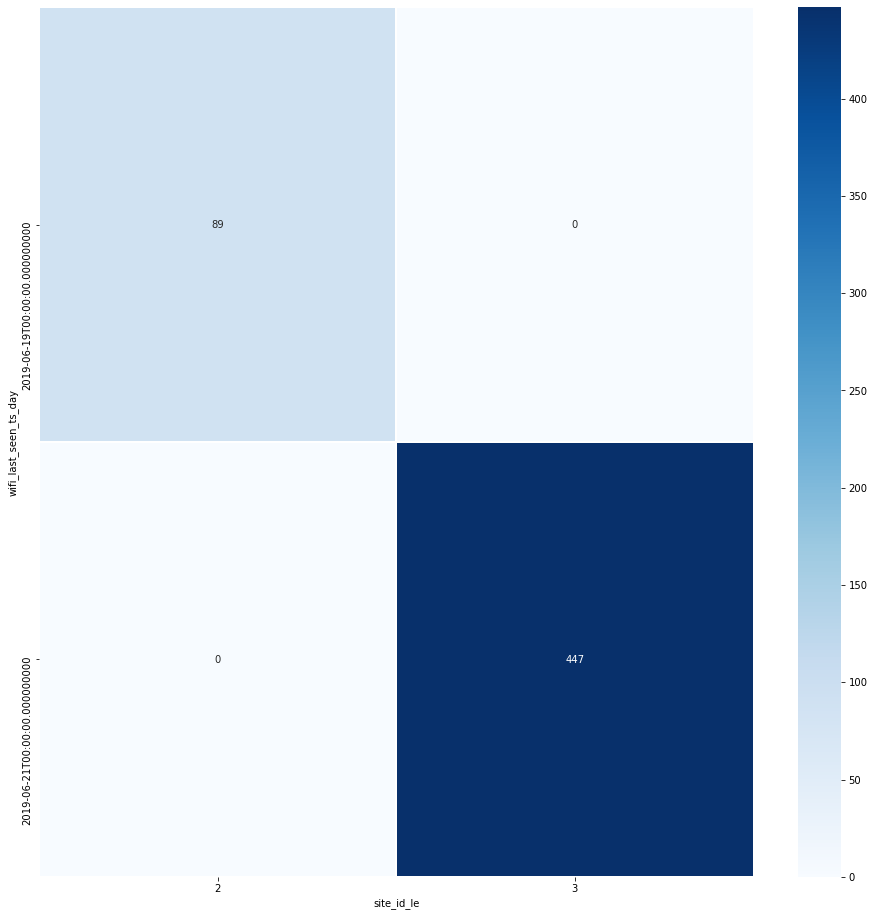

In [19]:
# Check dates distribution by heatmap with train data
piv_df = df_combine_train.pivot_table(index="wifi_last_seen_ts_day", columns="site_id_le", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

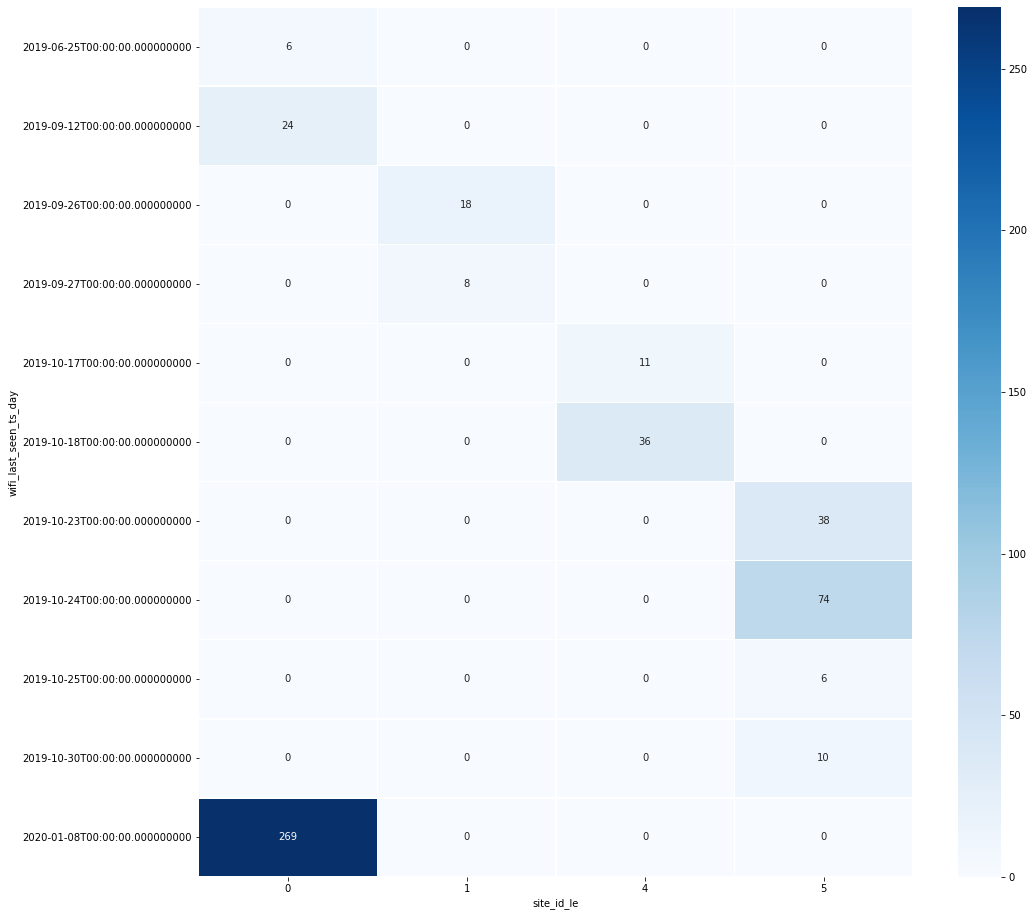

In [20]:
# Check dates distribution by heatmap with test data
# Result: No overlap in buildings between train and test, and how it can be measured on different dates is the same as well
piv_df = df_combine_test.pivot_table(index="wifi_last_seen_ts_day", columns="site_id_le", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

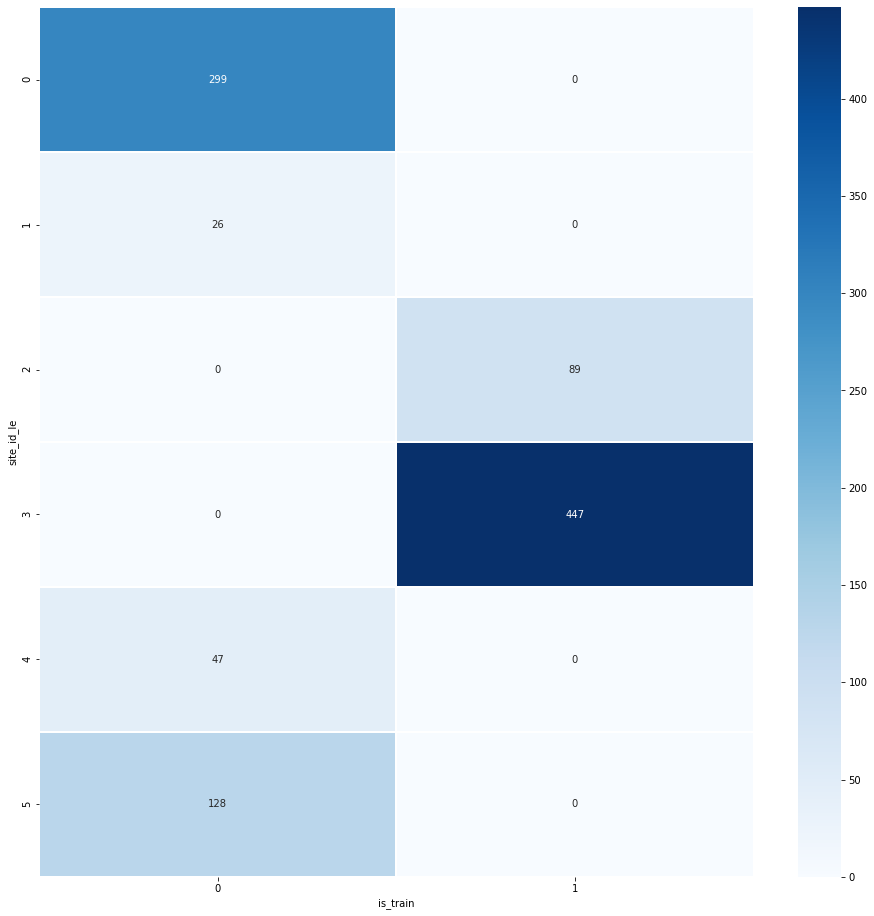

In [21]:
# Check for any overlap between train and test for site_id
# Result: No overlap of buildings 
piv_df = df_combine.pivot_table(index="site_id_le", columns="is_train", aggfunc="size", fill_value=0)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(piv_df, annot=True,  linewidths=.5, cmap="Blues", ax=ax, fmt="g")
plt.show()

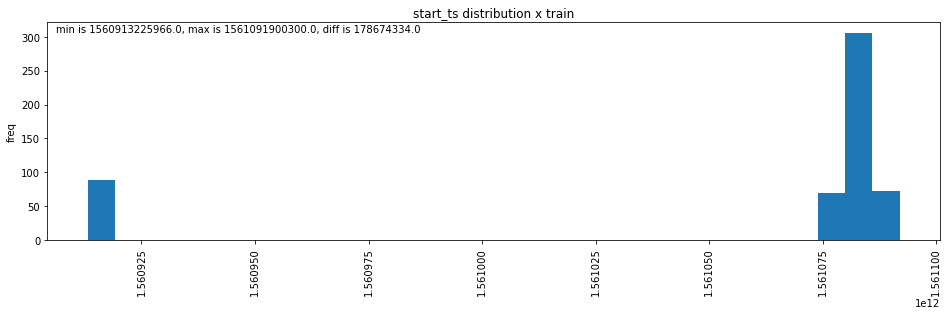

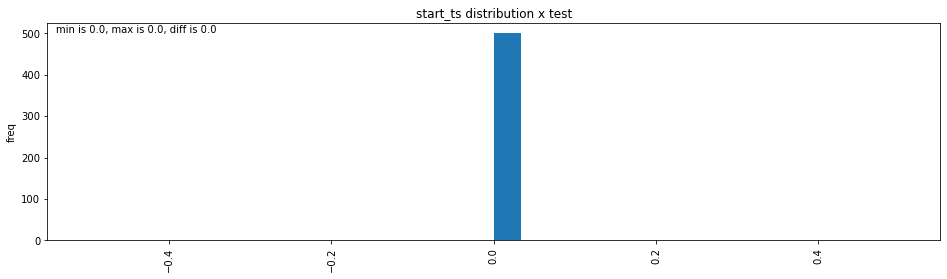

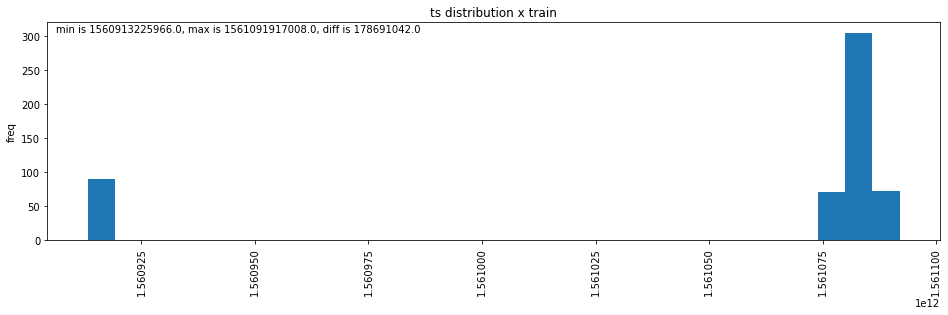

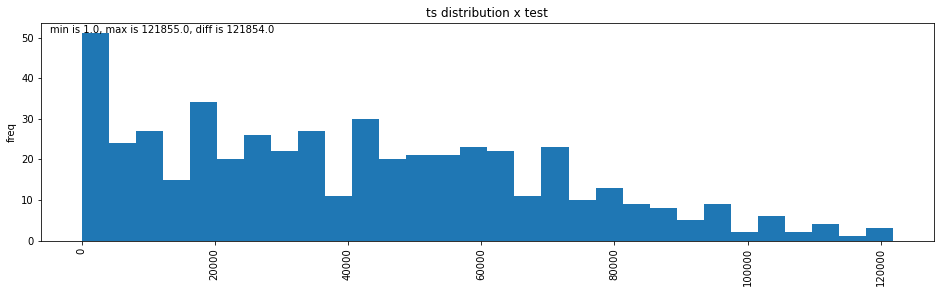

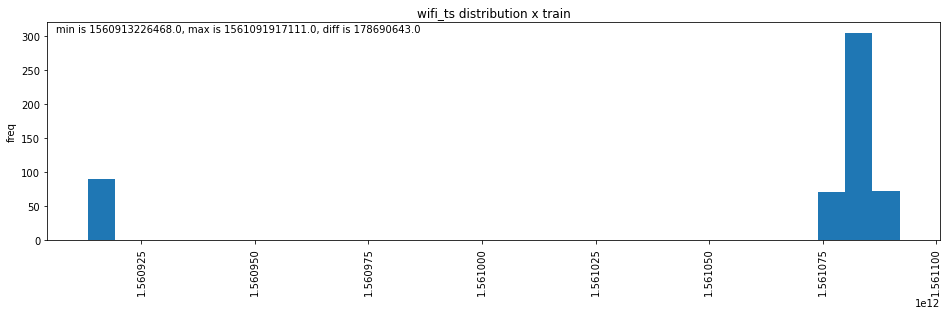

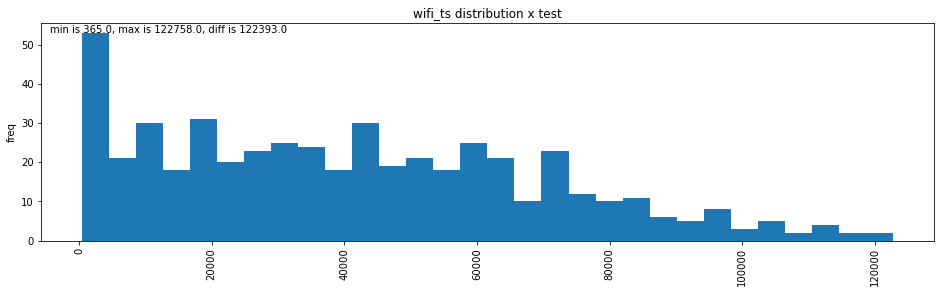

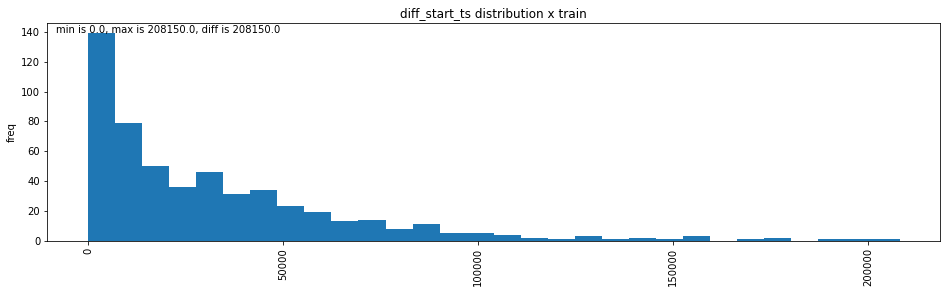

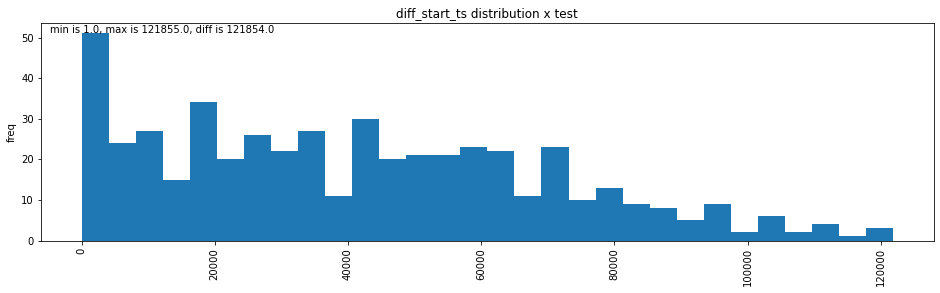

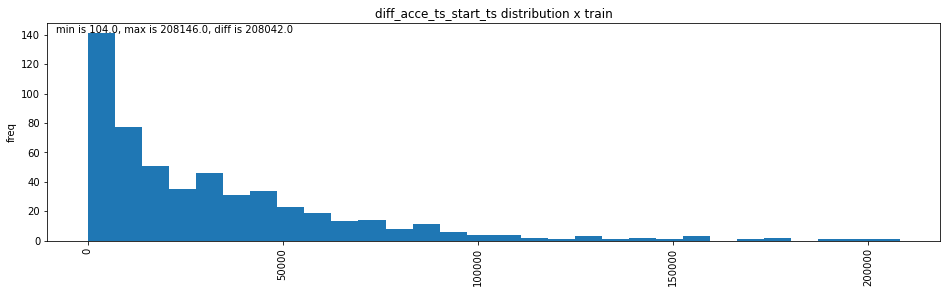

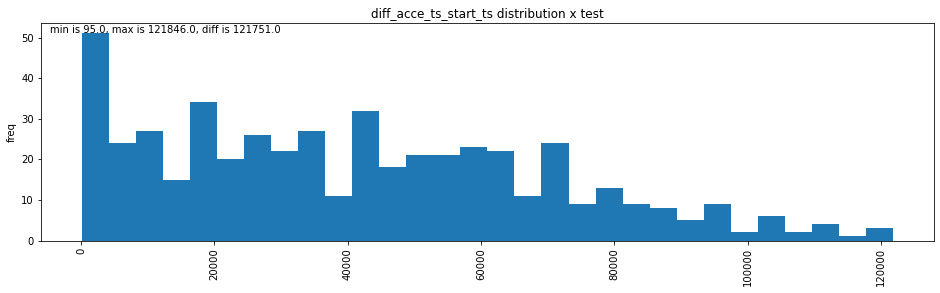

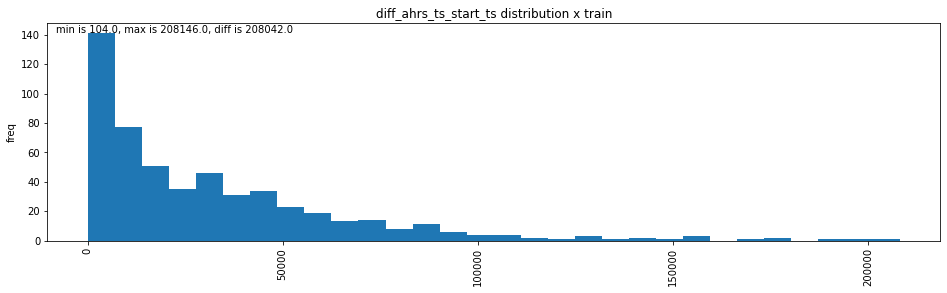

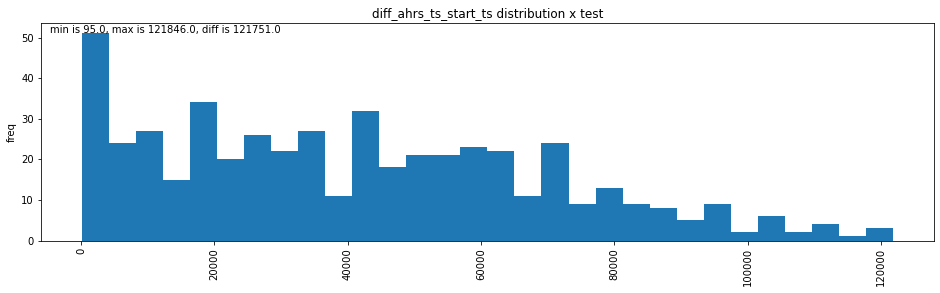

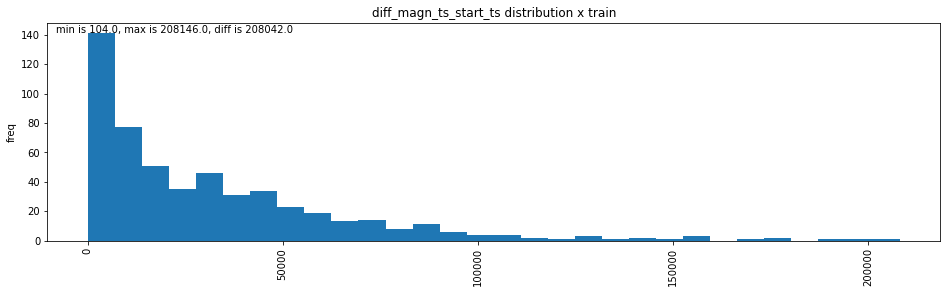

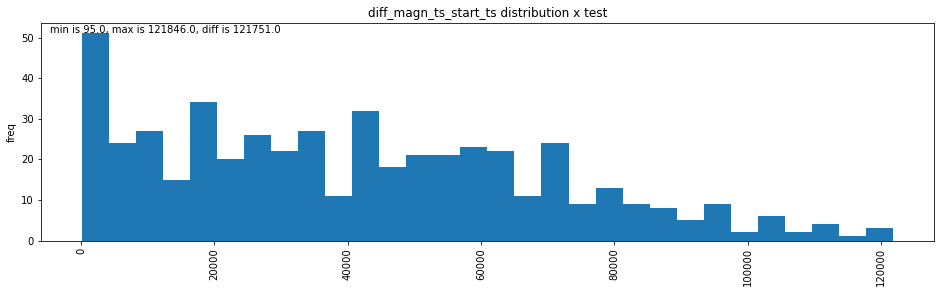

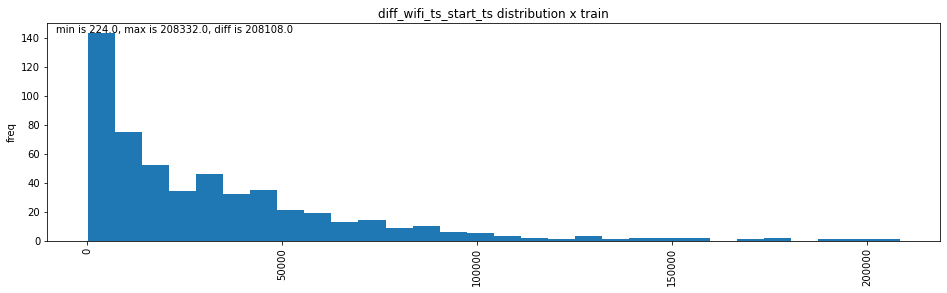

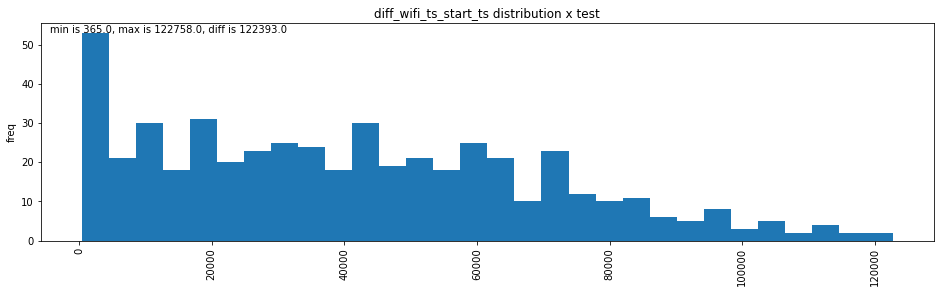

In [22]:
# bin and plot distribution : start_ts, ts, wifi_last_seen
# (don't plot them on the same scale)

# ["start_ts", "ts", "wifi_ts", "wifi_last_seen_ts"] distribution x [df_train, df_test]
start = time.time() # just in case
cols_to_plot = ["start_ts", "ts", "wifi_ts", "diff_start_ts", \
                "diff_acce_ts_start_ts", "diff_ahrs_ts_start_ts", \
                "diff_magn_ts_start_ts", "diff_wifi_ts_start_ts"]

for col in cols_to_plot:
    for df in [df_train, df_test]:
        df_title = "train" if df.name == "df_train" else "test"
        bin_plot(df, col, f"{col} distribution x {df_title}", f"{col}", "freq")

# print("time to process", time.time() - start)

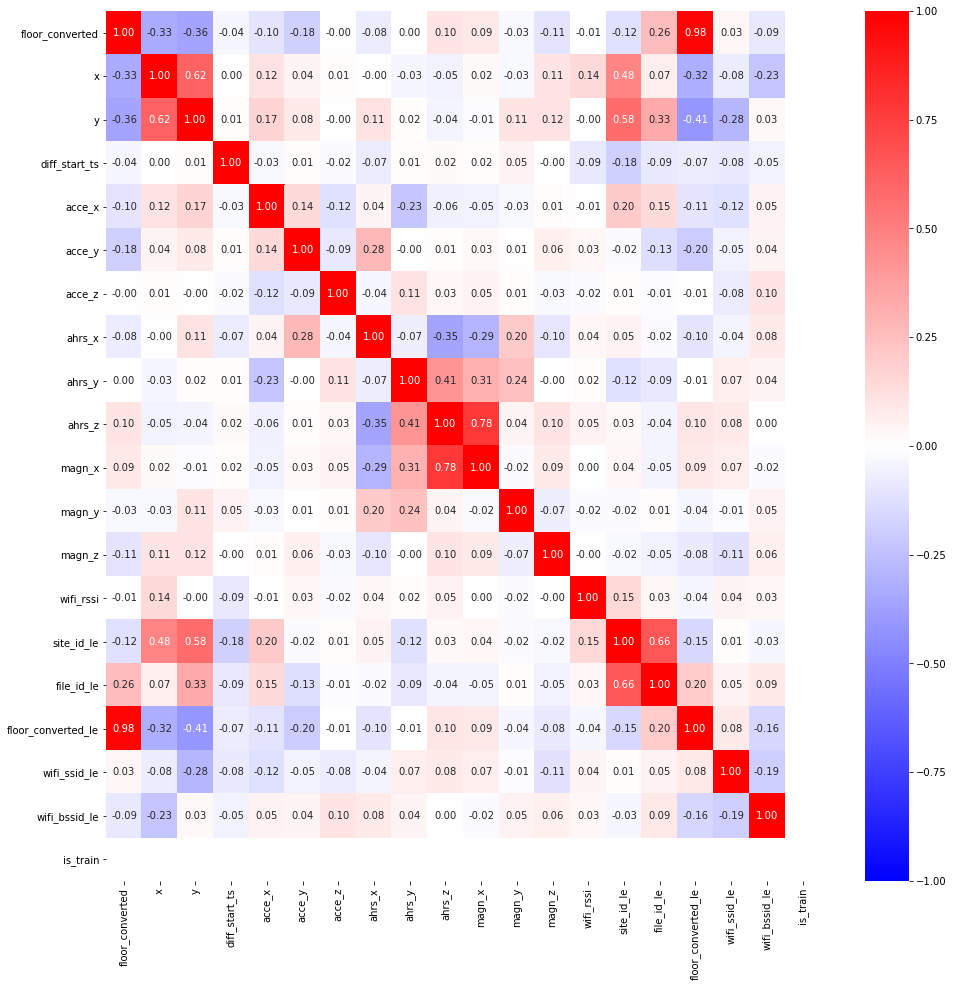

In [23]:
corr = df_train_num_le.corr()
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(corr, annot=True,  cmap="bwr", ax=ax, fmt=".2f", robust=True, vmin=-1,vmax=1)
plt.show()

In [ ]:
# pairplot by floor as hue using the numeric columns only
# sns.pairplot(df_train_num, hue='floor_converted')

In [ ]:
# pairplot by building as hue
# Narrow combined df down to numeric ones only but this time keep site_id anf file_id
# sns.pairplot(df_combine_reduced, hue='site_id')

In [ ]:
# Narrow combined df down to numeric ones only
# display(df_combine_num.head())
# sns.pairplot(df_combine_num, hue='is_train')